<a href=""><img src = "" width = 400> </a>

<h1 align=center><font size = 5>Capstone Project - The Battle of NY Neighborhoods</font></h1>

## Introduction

 
 
 
In this project, we will explore neighborhoods in New York City using Foursquare API to explore neighborhoods. I will get the most common venue categories in each neighborhood, and then use this feature to group the neighborhoods into clusters. The *k*-means clustering algorithm will be used to complete this task. Finally, useing the Folium library to visualize the neighborhoods in New York City and their emerging clusters.

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

1. <a href="#item1">Download and Explore Dataset</a>

2. <a href="#item2">Explore Neighborhoods in New York City</a>

3. <a href="#item3">Analyze Each Neighborhood</a>

4. <a href="#item4">Cluster Neighborhoods</a>

5. <a href="#item5">Examine Clusters</a>    
</font>
</div>

Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library


print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Libraries imported.


<a id='item1'></a>

## 1. Download and Explore Dataset

### Population of NY based on boroughs

In [2]:
ca_post = pd.read_html('https://www.census.gov/quickfacts/fact/table/newyorkcitynewyork,bronxcountybronxboroughnewyork,kingscountybrooklynboroughnewyork,newyorkcountymanhattanboroughnewyork,queenscountyqueensboroughnewyork,richmondcountystatenislandboroughnewyork/PST045219', header=0)[0]
ca_post.columns = ['population', 'New York','Bronx','Brooklyn','Manhattan','Queens','Staten Island']
ca_post.drop(['New York'], axis=1,inplace=True)
ca_post.head()

,population,Bronx,Brooklyn,Manhattan,Queens,Staten Island
0,"Population estimates, July 1, 2019, (V2019)",1432132,2582830,1628701,2278906,476179


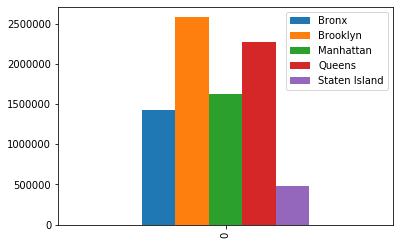

In [4]:
ca_post.plot(kind='bar')

### Brooklen has the most population rate followed by Queens and Manhattan

Neighborhood has a total of 5 boroughs and 306 neighborhoods. In order to segement the neighborhoods and explore them, we will essentially need a dataset that contains the 5 boroughs and the neighborhoods that exist in each borough as well as the the latitude and logitude coordinates of each neighborhood. 

Luckily, this dataset exists for free on the web. Feel free to try to find this dataset on your own, but here is the link to the dataset: https://geo.nyu.edu/catalog/nyu_2451_34572

For your convenience, I downloaded the files and placed it on the server, so you can simply run a `wget` command and access the data. So let's go ahead and do that.

#### Load and explore the data

Next, let's load the data.

In [5]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

Let's take a quick look at the data.

In [12]:
#newyork_data

Notice how all the relevant data is in the *features* key, which is basically a list of the neighborhoods. So, let's define a new variable that includes this data.

In [6]:
neighborhoods_data = newyork_data['features']

Let's take a look at the first item in this list.

In [7]:
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

#### Tranform the data into a *pandas* dataframe

The next task is essentially transforming this data of nested Python dictionaries into a *pandas* dataframe. So let's start by creating an empty dataframe.

In [8]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

Take a look at the empty dataframe to confirm that the columns are as intended.

In [9]:
neighborhoods

,Borough,Neighborhood,Latitude,Longitude


Then let's loop through the data and fill the dataframe one row at a time.

In [10]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

Quickly examine the resulting dataframe.

In [11]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [12]:
neighborhoods['Borough'].unique()

array(['Bronx', 'Manhattan', 'Brooklyn', 'Queens', 'Staten Island'],
      dtype=object)

And make sure that the dataset has all 5 boroughs and 306 neighborhoods.

In [13]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


#### Use geopy library to get the latitude and longitude values of New York City.

In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent <em>ny_explorer</em>, as shown below.

In [14]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


#### Create a map of New York with neighborhoods superimposed on top.

In [15]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

**Folium** is a great visualization library. Feel free to zoom into the above map, and click on each circle mark to reveal the name of the neighborhood and its respective borough.

However, for illustration purposes, let's simplify the above map and segment and cluster only the neighborhoods in Manhattan. So let's slice the original dataframe and create a new dataframe of the Manhattan data.

In [16]:
brooklyn_data = neighborhoods[neighborhoods['Borough'] == 'Brooklyn'].reset_index(drop=True)
brooklyn_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Brooklyn,Bay Ridge,40.625801,-74.030621
1,Brooklyn,Bensonhurst,40.611009,-73.995180
2,Brooklyn,Sunset Park,40.645103,-74.010316
3,Brooklyn,Greenpoint,40.730201,-73.954241
4,Brooklyn,Gravesend,40.595260,-73.973471


In [17]:
brooklyn_data.shape

(70, 4)

In [18]:
queens_data = neighborhoods[neighborhoods['Borough'] == 'Queens'].reset_index(drop=True)
queens_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Queens,Astoria,40.768509,-73.915654
1,Queens,Woodside,40.746349,-73.901842
2,Queens,Jackson Heights,40.751981,-73.882821
3,Queens,Elmhurst,40.744049,-73.881656
4,Queens,Howard Beach,40.654225,-73.838138


In [19]:
queens_data.shape

(81, 4)

In [39]:
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


In [21]:
manhattan_data.shape

(40, 4)

Let's get the geographical coordinates of Manhattan.

In [22]:
address = 'Brooklyn, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Brooklyn are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Brooklyn are 40.6501038, -73.9495823.


In [23]:
# create map of Brooklyn using latitude and longitude values
map_brooklyn = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(brooklyn_data['Latitude'], brooklyn_data['Longitude'], brooklyn_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_brooklyn)  
    
map_brooklyn

In [24]:
address = 'Queens, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Queens are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Queens are 40.7498243, -73.7976337.


In [25]:
# create map of Queens using latitude and longitude values
map_queens = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(queens_data['Latitude'], queens_data['Longitude'], queens_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_queens)  
    
map_queens

In [26]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan are 40.7896239, -73.9598939.


In [27]:
# create map of Manhattan using latitude and longitude values
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)  
    
map_manhattan

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

#### Define Foursquare Credentials and Version

In [28]:
CLIENT_ID = 'UKJHKIOV2ZD4DVAUTL2NXJ1OKTHZJNELMGAK5W202VERVFPS' # your Foursquare ID
CLIENT_SECRET = '10BM3L2IKWYL24XNSVQWCKJQCIPBFJ2X1SE1VSVHE2NCJ20G' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: UKJHKIOV2ZD4DVAUTL2NXJ1OKTHZJNELMGAK5W202VERVFPS
CLIENT_SECRET:10BM3L2IKWYL24XNSVQWCKJQCIPBFJ2X1SE1VSVHE2NCJ20G


<a id='item2'></a>

## 2. Explore Neighborhoods in Brooklyn

#### Let's create a function to repeat the same process to all the neighborhoods in Manhattan

In [34]:
LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 500 # define radius

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
# type your answer here

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Now write the code to run the above function on each neighborhood and create a new dataframe called *manhattan_venues*.

In [35]:
# type your answer here

brooklyn_venues = getNearbyVenues(names=brooklyn_data['Neighborhood'],
                                   latitudes=brooklyn_data['Latitude'],
                                   longitudes=brooklyn_data['Longitude']
                                  )



Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker Heights
Gerritsen Beach
Marine Park
Clinton Hill
Sea Gate
Downtown
Boerum Hill
Prospect Lefferts Gardens
Ocean Hill
City Line
Bergen Beach
Midwood
Prospect Park South
Georgetown
East Williamsburg
North Side
South Side
Ocean Parkway
Fort Hamilton
Ditmas Park
Wingate
Rugby
Remsen Village
New Lots
Paerdegat Basin
Mill Basin
Fulton Ferry
Vinegar Hill
Weeksville
Broadway Junction
Dumbo
Homecrest
Highland Park
Madison
Erasmus


In [37]:
# type your answer here

queens_venues = getNearbyVenues(names=queens_data['Neighborhood'],
                                   latitudes=queens_data['Latitude'],
                                   longitudes=queens_data['Longitude']
                                  )



Astoria
Woodside
Jackson Heights
Elmhurst
Howard Beach
Corona
Forest Hills
Kew Gardens
Richmond Hill
Flushing
Long Island City
Sunnyside
East Elmhurst
Maspeth
Ridgewood
Glendale
Rego Park
Woodhaven
Ozone Park
South Ozone Park
College Point
Whitestone
Bayside
Auburndale
Little Neck
Douglaston
Glen Oaks
Bellerose
Kew Gardens Hills
Fresh Meadows
Briarwood
Jamaica Center
Oakland Gardens
Queens Village
Hollis
South Jamaica
St. Albans
Rochdale
Springfield Gardens
Cambria Heights
Rosedale
Far Rockaway
Broad Channel
Breezy Point
Steinway
Beechhurst
Bay Terrace
Edgemere
Arverne
Rockaway Beach
Neponsit
Murray Hill
Floral Park
Holliswood
Jamaica Estates
Queensboro Hill
Hillcrest
Ravenswood
Lindenwood
Laurelton
Lefrak City
Belle Harbor
Rockaway Park
Somerville
Brookville
Bellaire
North Corona
Forest Hills Gardens
Jamaica Hills
Utopia
Pomonok
Astoria Heights
Hunters Point
Sunnyside Gardens
Blissville
Roxbury
Middle Village
Malba
Hammels
Bayswater
Queensbridge


In [40]:
# type your answer here

manhaten_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )



Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


Double-click __here__ for the solution.
<!-- The correct answer is:
manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )
--> 

#### Let's check the size of the resulting dataframe

In [69]:
print(brooklyn_venues.shape)
brooklyn_venues.head()

(2791, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bay Ridge,40.625801,-74.030621,Pilo Arts Day Spa and Salon,40.624748,-74.030591,Spa
1,Bay Ridge,40.625801,-74.030621,Bagel Boy,40.627896,-74.029335,Bagel Shop
2,Bay Ridge,40.625801,-74.030621,Cocoa Grinder,40.623967,-74.030863,Juice Bar
3,Bay Ridge,40.625801,-74.030621,Pegasus Cafe,40.623168,-74.031186,Breakfast Spot
4,Bay Ridge,40.625801,-74.030621,Ho' Brah Taco Joint,40.622960,-74.031371,Taco Place


In [41]:
brooklyn_nearby_venues=brooklyn_venues[brooklyn_venues['Venue Category'].str.contains('Gym')]
queens_nearby_venues=queens_venues[queens_venues['Venue Category'].str.contains('Gym')]
manhaten_nearby_venues=manhaten_venues[manhaten_venues['Venue Category'].str.contains('Gym')]

In [110]:
print('{} venues were returned by Foursquare.'.format(brooklyn_nearby_venues.shape[0]))

54 venues were returned by Foursquare.


In [111]:
print('{} venues were returned by Foursquare.'.format(queens_nearby_venues.shape[0]))

55 venues were returned by Foursquare.


In [112]:
print('{} venues were returned by Foursquare.'.format(manhaten_nearby_venues.shape[0]))


120 venues were returned by Foursquare.


In [113]:
brk_df = brooklyn_nearby_venues.groupby('Neighborhood').count()
que_df = queens_nearby_venues.groupby('Neighborhood').count()
man_df = manhaten_nearby_venues.groupby('Neighborhood').count()

In [114]:
brk_df.shape

(32, 6)

In [115]:
que_df.shape

(29, 6)

In [116]:
man_df.shape

(33, 6)

In [117]:
brooklyn_nearby_venues.groupby('Venue Category').count()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
Boxing Gym,5,5,5,5,5,5
Climbing Gym,1,1,1,1,1,1
Gym,20,20,20,20,20,20
Gym / Fitness Center,26,26,26,26,26,26
Gymnastics Gym,2,2,2,2,2,2


Let's check how many venues were returned for each neighborhood

In [52]:
brooklyn_nearby_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Bay Ridge,1,1,1,1,1,1
Boerum Hill,2,2,2,2,2,2
Brooklyn Heights,5,5,5,5,5,5
Bushwick,1,1,1,1,1,1
Canarsie,1,1,1,1,1,1
Carroll Gardens,3,3,3,3,3,3
Clinton Hill,1,1,1,1,1,1
Cobble Hill,1,1,1,1,1,1
Ditmas Park,1,1,1,1,1,1


In [54]:
brooklyn_venues[brooklyn_venues['Venue Category'].str.contains("Gym")].head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
65,Bay Ridge,40.625801,-74.030621,New York Sports Clubs,40.622364,-74.027163,Gym / Fitness Center
133,Sunset Park,40.645103,-74.010316,Blink Fitness,40.645502,-74.013143,Gym
142,Sunset Park,40.645103,-74.010316,Richie's Gym,40.645354,-74.013609,Gym
156,Greenpoint,40.730201,-73.954241,IncrediPole,40.731838,-73.955069,Gymnastics Gym
257,Gravesend,40.595260,-73.973471,Fitness by kobi,40.594098,-73.973310,Gym


#### Let's find out how many unique categories can be curated from all the returned venues

In [55]:
print('There are {} uniques categories.'.format(len(brooklyn_nearby_venues['Venue Category'].unique())))

There are 5 uniques categories.


<a id='item3'></a>

## 3. Analyze Each Neighborhood

In [56]:
# one hot encoding
brooklyn_onehot = pd.get_dummies(brooklyn_nearby_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
brooklyn_onehot['Neighborhood'] = brooklyn_nearby_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [brooklyn_onehot.columns[-1]] + list(brooklyn_onehot.columns[:-1])
brooklyn_onehot = brooklyn_onehot[fixed_columns]

brooklyn_onehot.head()

,Neighborhood,Boxing Gym,Climbing Gym,Gym,Gym / Fitness Center,Gymnastics Gym
65,Bay Ridge,0,0,0,1,0
133,Sunset Park,0,0,1,0,0
142,Sunset Park,0,0,1,0,0
156,Greenpoint,0,0,0,0,1
257,Gravesend,0,0,1,0,0


And let's examine the new dataframe size.

In [57]:
brooklyn_onehot.shape

(54, 6)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [58]:
brooklyn_grouped = brooklyn_onehot.groupby('Neighborhood').mean().reset_index()
brooklyn_grouped

,Neighborhood,Boxing Gym,Climbing Gym,Gym,Gym / Fitness Center,Gymnastics Gym
0,Bay Ridge,0.000000,0.0,0.000000,1.000000,0.000000
1,Boerum Hill,0.000000,0.0,0.000000,1.000000,0.000000
2,Brooklyn Heights,0.000000,0.0,0.600000,0.400000,0.000000
3,Bushwick,0.000000,0.0,1.000000,0.000000,0.000000
4,Canarsie,0.000000,0.0,1.000000,0.000000,0.000000
5,Carroll Gardens,0.000000,0.0,0.000000,1.000000,0.000000
6,Clinton Hill,1.000000,0.0,0.000000,0.000000,0.000000
7,Cobble Hill,0.000000,0.0,0.000000,1.000000,0.000000
8,Ditmas Park,0.000000,0.0,0.000000,1.000000,0.000000
9,Downtown,0.000000,0.0,0.500000,0.500000,0.000000


#### Let's confirm the new size

In [59]:
brooklyn_grouped.shape

(32, 6)

#### Let's print each neighborhood along with the top 5 most common venues

In [60]:
num_top_venues = 5

for hood in brooklyn_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = brooklyn_grouped[brooklyn_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Bay Ridge----
                  venue  freq
0  Gym / Fitness Center   1.0
1            Boxing Gym   0.0
2          Climbing Gym   0.0
3                   Gym   0.0
4        Gymnastics Gym   0.0


----Boerum Hill----
                  venue  freq
0  Gym / Fitness Center   1.0
1            Boxing Gym   0.0
2          Climbing Gym   0.0
3                   Gym   0.0
4        Gymnastics Gym   0.0


----Brooklyn Heights----
                  venue  freq
0                   Gym   0.6
1  Gym / Fitness Center   0.4
2            Boxing Gym   0.0
3          Climbing Gym   0.0
4        Gymnastics Gym   0.0


----Bushwick----
                  venue  freq
0                   Gym   1.0
1            Boxing Gym   0.0
2          Climbing Gym   0.0
3  Gym / Fitness Center   0.0
4        Gymnastics Gym   0.0


----Canarsie----
                  venue  freq
0                   Gym   1.0
1            Boxing Gym   0.0
2          Climbing Gym   0.0
3  Gym / Fitness Center   0.0
4        Gymnastics Gym  

#### Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [61]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [62]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = brooklyn_grouped['Neighborhood']

for ind in np.arange(brooklyn_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(brooklyn_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Bay Ridge,Gym / Fitness Center,Gymnastics Gym,Gym,Climbing Gym,Boxing Gym
1,Boerum Hill,Gym / Fitness Center,Gymnastics Gym,Gym,Climbing Gym,Boxing Gym
2,Brooklyn Heights,Gym,Gym / Fitness Center,Gymnastics Gym,Climbing Gym,Boxing Gym
3,Bushwick,Gym,Gymnastics Gym,Gym / Fitness Center,Climbing Gym,Boxing Gym
4,Canarsie,Gym,Gymnastics Gym,Gym / Fitness Center,Climbing Gym,Boxing Gym
5,Carroll Gardens,Gym / Fitness Center,Gymnastics Gym,Gym,Climbing Gym,Boxing Gym
6,Clinton Hill,Boxing Gym,Gymnastics Gym,Gym / Fitness Center,Gym,Climbing Gym
7,Cobble Hill,Gym / Fitness Center,Gymnastics Gym,Gym,Climbing Gym,Boxing Gym
8,Ditmas Park,Gym / Fitness Center,Gymnastics Gym,Gym,Climbing Gym,Boxing Gym
9,Downtown,Gym / Fitness Center,Gym,Gymnastics Gym,Climbing Gym,Boxing Gym


<a id='item4'></a>

## 4. Cluster Neighborhoods

Run *k*-means to cluster the neighborhood into 5 clusters.

In [93]:
# set number of clusters
kclusters = 4

brooklyn_grouped_clusters = brooklyn_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(brooklyn_grouped_clusters)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 2, 1, 1, 0, 2, 0, 0, 2], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [95]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Label', kmeans.labels_)

brooklyn_merged = brooklyn_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
brooklyn_merged = brooklyn_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

brooklyn_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Label,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Brooklyn,Bay Ridge,40.625801,-74.030621,0.0,0.0,Gym / Fitness Center,Gymnastics Gym,Gym,Climbing Gym,Boxing Gym
1,Brooklyn,Bensonhurst,40.611009,-73.995180,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Brooklyn,Sunset Park,40.645103,-74.010316,1.0,1.0,Gym,Gymnastics Gym,Gym / Fitness Center,Climbing Gym,Boxing Gym
3,Brooklyn,Greenpoint,40.730201,-73.954241,3.0,2.0,Gymnastics Gym,Gym / Fitness Center,Gym,Climbing Gym,Boxing Gym
4,Brooklyn,Gravesend,40.595260,-73.973471,1.0,1.0,Gym,Gymnastics Gym,Gym / Fitness Center,Climbing Gym,Boxing Gym


In [96]:
null_columns=brooklyn_merged.columns[brooklyn_merged.isnull().any()]
brooklyn_merged[null_columns].isnull().sum()

Cluster Label            38
Cluster Labels           38
1st Most Common Venue    38
2nd Most Common Venue    38
3rd Most Common Venue    38
4th Most Common Venue    38
5th Most Common Venue    38
dtype: int64

In [99]:
brooklyn_merged=brooklyn_merged.fillna(3)

In [100]:
null_columns=brooklyn_merged.columns[brooklyn_merged.isnull().any()]
brooklyn_merged[null_columns].isnull().sum()

Series([], dtype: float64)

In [101]:
brooklyn_merged['Cluster Labels'] = brooklyn_merged['Cluster Labels'].astype(int)

In [102]:
brooklyn_merged.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Label,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Brooklyn,Bay Ridge,40.625801,-74.030621,0.0,0,Gym / Fitness Center,Gymnastics Gym,Gym,Climbing Gym,Boxing Gym
1,Brooklyn,Bensonhurst,40.611009,-73.995180,3.0,3,3,3,3,3,3
2,Brooklyn,Sunset Park,40.645103,-74.010316,1.0,1,Gym,Gymnastics Gym,Gym / Fitness Center,Climbing Gym,Boxing Gym
3,Brooklyn,Greenpoint,40.730201,-73.954241,3.0,2,Gymnastics Gym,Gym / Fitness Center,Gym,Climbing Gym,Boxing Gym
4,Brooklyn,Gravesend,40.595260,-73.973471,1.0,1,Gym,Gymnastics Gym,Gym / Fitness Center,Climbing Gym,Boxing Gym


Finally, let's visualize the resulting clusters

In [118]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(brooklyn_merged['Latitude'], brooklyn_merged['Longitude'], brooklyn_merged['Neighborhood'], brooklyn_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<a id='item5'></a>

## 5. Examine Clusters

Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, you can then assign a name to each cluster. I will leave this exercise to you.

#### Cluster 1

In [104]:
brooklyn_merged.loc[brooklyn_merged['Cluster Labels'] == 0, brooklyn_merged.columns[[1] + list(range(5, brooklyn_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Bay Ridge,0,Gym / Fitness Center,Gymnastics Gym,Gym,Climbing Gym,Boxing Gym
19,Cobble Hill,0,Gym / Fitness Center,Gymnastics Gym,Gym,Climbing Gym,Boxing Gym
20,Carroll Gardens,0,Gym / Fitness Center,Gymnastics Gym,Gym,Climbing Gym,Boxing Gym
22,Gowanus,0,Gym / Fitness Center,Gymnastics Gym,Gym,Climbing Gym,Boxing Gym
23,Fort Greene,0,Gym / Fitness Center,Gymnastics Gym,Gym,Climbing Gym,Boxing Gym
24,Park Slope,0,Gym / Fitness Center,Gymnastics Gym,Gym,Climbing Gym,Boxing Gym
41,Boerum Hill,0,Gym / Fitness Center,Gymnastics Gym,Gym,Climbing Gym,Boxing Gym
47,Prospect Park South,0,Gym / Fitness Center,Gymnastics Gym,Gym,Climbing Gym,Boxing Gym
49,East Williamsburg,0,Gym / Fitness Center,Gymnastics Gym,Gym,Climbing Gym,Boxing Gym
53,Fort Hamilton,0,Gym / Fitness Center,Gymnastics Gym,Gym,Climbing Gym,Boxing Gym


#### Cluster 2

In [105]:
brooklyn_merged.loc[brooklyn_merged['Cluster Labels'] == 1, brooklyn_merged.columns[[1] + list(range(5, brooklyn_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
2,Sunset Park,1,Gym,Gymnastics Gym,Gym / Fitness Center,Climbing Gym,Boxing Gym
4,Gravesend,1,Gym,Gymnastics Gym,Gym / Fitness Center,Climbing Gym,Boxing Gym
11,Kensington,1,Gym,Gymnastics Gym,Gym / Fitness Center,Climbing Gym,Boxing Gym
15,Williamsburg,1,Gym,Gymnastics Gym,Gym / Fitness Center,Climbing Gym,Boxing Gym
16,Bushwick,1,Gym,Gymnastics Gym,Gym / Fitness Center,Climbing Gym,Boxing Gym
26,East New York,1,Gym,Gymnastics Gym,Gym / Fitness Center,Climbing Gym,Boxing Gym
28,Canarsie,1,Gym,Gymnastics Gym,Gym / Fitness Center,Climbing Gym,Boxing Gym
37,Marine Park,1,Gym,Gymnastics Gym,Gym / Fitness Center,Climbing Gym,Boxing Gym
59,Paerdegat Basin,1,Gym,Gymnastics Gym,Gym / Fitness Center,Climbing Gym,Boxing Gym
60,Mill Basin,1,Gym,Gymnastics Gym,Gym / Fitness Center,Climbing Gym,Boxing Gym


#### Cluster 3

In [106]:
brooklyn_merged.loc[brooklyn_merged['Cluster Labels'] == 2, brooklyn_merged.columns[[1] + list(range(5, brooklyn_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
3,Greenpoint,2,Gymnastics Gym,Gym / Fitness Center,Gym,Climbing Gym,Boxing Gym
18,Brooklyn Heights,2,Gym,Gym / Fitness Center,Gymnastics Gym,Climbing Gym,Boxing Gym
38,Clinton Hill,2,Boxing Gym,Gymnastics Gym,Gym / Fitness Center,Gym,Climbing Gym
40,Downtown,2,Gym / Fitness Center,Gym,Gymnastics Gym,Climbing Gym,Boxing Gym
50,North Side,2,Gym,Boxing Gym,Gymnastics Gym,Gym / Fitness Center,Climbing Gym
51,South Side,2,Gym / Fitness Center,Gym,Boxing Gym,Gymnastics Gym,Climbing Gym
52,Ocean Parkway,2,Gym / Fitness Center,Gym,Gymnastics Gym,Climbing Gym,Boxing Gym
65,Dumbo,2,Gym,Boxing Gym,Climbing Gym,Gymnastics Gym,Gym / Fitness Center


#### Cluster 4

In [109]:
brooklyn_merged.Neighborhood.loc[brooklyn_merged['Cluster Labels'] == 3]

1                   Bensonhurst
5                Brighton Beach
6                Sheepshead Bay
7             Manhattan Terrace
8                      Flatbush
9                 Crown Heights
10                East Flatbush
12              Windsor Terrace
13             Prospect Heights
14                  Brownsville
17           Bedford Stuyvesant
21                     Red Hook
25                Cypress Hills
27                Starrett City
29                    Flatlands
30                  Mill Island
31              Manhattan Beach
32                 Coney Island
33                   Bath Beach
34                 Borough Park
35                Dyker Heights
36              Gerritsen Beach
39                     Sea Gate
42    Prospect Lefferts Gardens
43                   Ocean Hill
44                    City Line
45                 Bergen Beach
46                      Midwood
48                   Georgetown
56                        Rugby
57               Remsen Village
58      

<hr>

Copyright &copy; 2018 [Cognitive Class](https://cognitiveclass.ai/?utm_source=bducopyrightlink&utm_medium=dswb&utm_campaign=bdu). This notebook and its source code are released under the terms of the [MIT License](https://bigdatauniversity.com/mit-license/).